This is to mount your drive and reference the network if you have it saved to your drive, which I'd do if you plan to use this network. If you don't mind waiting you can save it in the temp google drive directory with the commented out !git command

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import cv2
os.chdir('/content/drive/MyDrive/Mask-RCNN-TF2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git 

In [2]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


This sets up the network, swap this with the intended network if you chose a different one.

In [3]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available)) 
  print('GPU Mem Free: {0:.0f}MB'.format(gpu.memoryFree) )


%cd /content/drive/MyDrive/Mask-RCNN-TF2

!pip install -q PyDrive
!pip install -r requirements.txt
!python setup.py install

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=5e65d4a7ea4363b6572a2180fe7c205e6cb492452bb59386fd2e9041c350e5ec
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
/content
     |████████████████████████████████| 26.5 MB 1.2 MB/s 
     |████████████████████████████████| 516.2 MB 4.5 kB/s 
     |████████████████████████████████| 377 kB 93.4 MB/s 
     |████████████████████████████████| 2.9 MB 57.9 MB/s 
     |████████████████████████████████| 454 kB 86.3 MB/s 
     |████████████████████████████████| 3.0 MB 58.7 MB/s 
     |████████████████████████████████| 50 kB 7.9 MB/s 
     |████████████████████████████████| 154 kB 80.0 MB/s 
     |████████████████████████████████| 296 kB 85.1 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator

In [5]:
#!/usr/bin/env python
# coding: utf-8

# # Mask R-CNN Demo
# 
# A quick intro to using the pre-trained model to detect and segment objects.

# In[18]:


import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, r"/content/drive/MyDrive/Mask-RCNN-TF2/samples/coco"))  # To find local version
import coco

get_ipython().run_line_magic('matplotlib', 'inline')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "fruits-360")


# ## Configurations
# 
# We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.
# 
# For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

# In[12]:


class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


# ## Create Model and Load Trained Weights

# In[13]:


# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)


# ## Class Names
# 
# The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.
# 
# To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.
# 
# To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
# ```
# # Load COCO dataset
# dataset = coco.CocoDataset()
# dataset.load_coco(COCO_DIR, "train")
# dataset.prepare()
# 
# # Print class names
# print(dataset.class_names)
# ```
# 
# We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

# In[27]:


# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


# ## Run Object Detection

# In[33]:


# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
filename = os.path.join(IMAGE_DIR,'Test','Banana Red','5_100.jpg')
print(IMAGE_DIR)
print(filename)



Using TensorFlow backend.



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available)) 
  print('GPU Mem Free: {0:.0f}MB'.format(gpu.memoryFree) )
printm()

Gen RAM Free: 25.9 GB
GPU Mem Free: 16280MB


In [6]:
import cv2
import csv
from timeit import default_timer as timer
import datetime

In [ ]:
# # image = skimage.io.imread('/content/standing still.jpg')
# # new_image = image[:,:,:3]
# # def create_central_pixels(rois_array):
# #     center_pixels = []
# #     for rois in rois_array:
# #         center = list(np.abs([(rois[1]+(rois[3]-rois[1])/2).astype(int),(rois[2]).astype(int)]))
# #         center_pixels.append(center)
# #     return center_pixels

# def detect_people(new_image):
#     results = model.detect([new_image], verbose=0)
#     r = results[0]
#     classes = r['class_ids']
#     confidence = r['scores']
#     person = np.where((classes == 1)&(confidence>0))
#     people_rois = r['rois'][person]
#     print('confidence:',r['scores'][person])


#     center_pixels = create_central_pixels(people_rois)

#     return center_pixels


# # plt.figure(figsize=(20,12))
# # start = timer()
# # cord_array =detect_people(new_image)
# # stop = timer()
# # print(cord_array)
# # for cords in cord_array:
# #     cv2.circle(new_image, (cords[0],cords[1]),20,(255, 0, 255), 10)

# # plt.title('Bottom Center Pixel Chosen')

# # plt.imshow(new_image);plt.axis('off')

# # print(np.shape(new_image))
# # print("Total Processing Time: ",stop-start,'seconds')

Example output referencing the bottom middle point of the bounding box.

[0.99987245 0.9995535  0.99899143 0.99464536 0.977487   0.96165234
 0.9455734  0.8825403  0.88219297]
[[230, 481], [97, 191], [229, 221]]
Total Processing Time:  0.4139586969999982 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


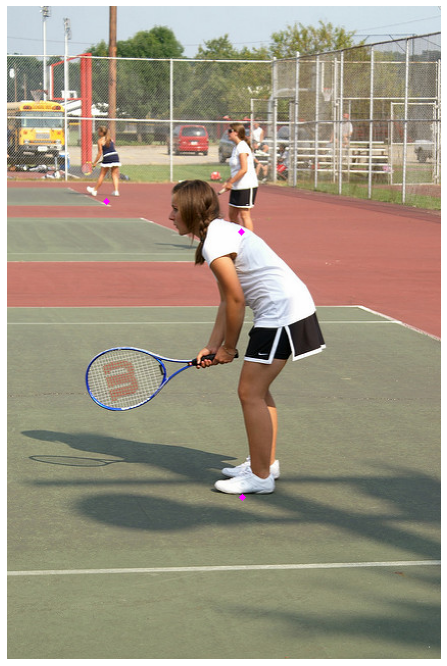

In [9]:
image = skimage.io.imread('/content/drive/MyDrive/Mask-RCNN-TF2/images/3862500489_6fd195d183_z.jpg')
new_image = image[:,:,:3]
scale = 1
new_image = cv2.resize(new_image,  (int(new_image.shape[1] * scale), int(new_image.shape[0] * scale)),interpolation = cv2.INTER_AREA)
def create_central_pixels(rois_array):
    center_pixels = []
    for rois in rois_array:
        center = list(np.abs([(rois[1]+(rois[3]-rois[1])/2).astype(np.int),(rois[2]).astype(np.int)]))
        center_pixels.append(center)
    return center_pixels

def detect_people(new_image):
    results = model.detect([new_image], verbose=0)
    r = results[0]
    classes = r['class_ids']
    confidence = r['scores']
    print(confidence)
    person = np.where((classes == 1)&(confidence>.97))
    people_rois = r['rois'][person]



    center_pixels = create_central_pixels(people_rois)

    return center_pixels


plt.figure(figsize=(20,12))
start = timer()
cord_array =detect_people(new_image)
stop = timer()
print(cord_array)
for cords in cord_array:
    cv2.circle(new_image, (cords[0],cords[1]),1,(255, 0, 255), 3)

plt.imshow(new_image);plt.axis('off')
print("Total Processing Time: ",stop-start,'seconds')



In [10]:
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

Code to grab timestamp

In [11]:
from skimage.util.dtype import img_as_bool
import cv2
import numpy as np



# cap = cv2.VideoCapture(r'/content/drive/Othercomputers/My Computer/Goddard Annex Week Final/01 24 22 N.avi')
# ret, img = cap.read()

def get_time_stamp_exit(frame):
  time_region = frame[0:20,85:160,0]
  thresh = 127
  im_bw = cv2.threshold(time_region, thresh, 255, cv2.THRESH_BINARY)[1]
  kernel = np.ones((2,2),np.uint8)
  dilation = cv2.dilate(time_region,kernel,iterations = 1)
  dilation = cv2.threshold(dilation, thresh, 255, cv2.THRESH_BINARY)[1]
  string = pytesseract.image_to_string(np.max(dilation)-dilation)
  return string[0:-2]

# print(get_time_stamp_exit(img))



Streaming output truncated to the last 5000 lines.
Expected Time Left: 0:34:25
confidence: [0.99529415 0.99342525]
confidence: [0.9968426  0.99248755]
confidence: [0.99128073 0.9862876 ]
confidence: [0.9991855  0.99448085]
confidence: [0.9993729  0.99644154]
confidence: [0.999271   0.99843365]
confidence: [0.99927825 0.9982139 ]
confidence: [0.99813336 0.9974064 ]
confidence: [0.99752027 0.99649954]
confidence: [0.9992924  0.99836165]
Progress: 66.5 %
Expected Time Left: 0:34:21
confidence: [0.9992337 0.9981516]
confidence: [0.99855524 0.9983735 ]
confidence: [0.9989147  0.99803144]
confidence: [0.99935776 0.99844545]
confidence: [0.9986524  0.99794215]
confidence: [0.9989293  0.99809486]
confidence: [0.99920005 0.99859875]
confidence: [0.9991553  0.99789315]
confidence: [0.9991868 0.9942485]
confidence: [0.9991561 0.9890415]
Progress: 66.60000000000001 %
Expected Time Left: 0:34:18
confidence: [0.9991447  0.92529553]
confidence: [0.99932325 0.9949537 ]
confidence: [0.99933296 0.998569

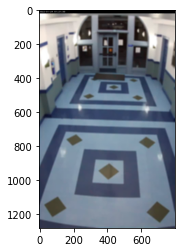

In [ ]:
# video_name = "/content/12 6 North .avi"
# csv_name ="SW Exit 11.08.2021 Rec 1.csv"
feed = r'1 24 22 SE blurred'

hall = feed.split(' ')[-2]
date = feed.split(' ')[0:-1]
print(' '.join(date))

#Name of the intended video to pull coordinates
cap = cv2.VideoCapture(r'/content/drive/MyDrive/Research Files/Hallway Sample.avi')
#Name of csv file that contains detections
filename   = r'/content/drive/MyDrive/Csv Locations/Hallway Sample.csv'

print('Processing:',filename)



total_frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

print(total_frame_count)
fps = cap.get(cv2.CAP_PROP_FPS)
vid_sec = total_frame_count/fps

start = timer()
vid_len = str(datetime.timedelta(seconds=vid_sec))
print("Length of Video:", vid_len)
expected_ratio = 3.5
expt_len = str(datetime.timedelta(seconds=vid_sec*expected_ratio))
print('Expected_Time: ', expt_len)

#Grab first and second frame
ret, frame1 = cap.read()
ret, frame2 = cap.read()
plt.imshow(frame1)
frame_count = 0
empty_frame_count = 0
with open(filename, 'w',newline='') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    while cap.isOpened():
        #Start Frame
        frame_count += 1
        # scale = 1
        # cv2.resize(frame1,  (int(frame1.shape[1] * scale), int(frame1.shape[0] * scale)),interpolation = cv2.INTER_AREA)

        #Display Images
        mask_frame1 = frame1.copy()
        mask_frame2 = frame2.copy()
        mask_frame1[0:125,0:670] = 0
        mask_frame1[0:200,550:670] = 0
        mask_frame1[0:200,0:330] = 0        
        mask_frame2[0:125,0:670] = 0
        mask_frame2[0:200,550:670] = 0
        mask_frame2[0:200,0:330] = 0        



        diff = cv2.absdiff(mask_frame1, mask_frame2)
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

        _, thresh = cv2.threshold(gray, 15, 150, cv2.THRESH_BINARY)

        if np.sum(thresh)>50000:
          cord_array = detect_people(frame1)
        else:
          cord_array = []

        if len(cord_array)!=0:
          time_stamp = get_time_stamp_exit(frame1)
            
        else:
          time_stamp = None

        
        # print(empty_frame_count >20,len(cord_array)>0)
        # if ((empty_frame_count >20) & (len(cord_array)>0)):
        #     print('e')
        #     csvwriter.writerow([time_stamp]) 
        #     empty_frame_count = 0

        # if (len(cord_array)>0):
        #     empty_frame_count = 0


        row = [time_stamp]
        for coord in cord_array:
            row += [coord]
        csvwriter.writerow(row) 

        #Reset frames
        
        frame1 = frame2 
    #     frame1 = cv2.GaussianBlur(frame1, (11,11), 5)

        ret, frame2 = cap.read()
        if frame2 is None:
          stop = timer()
          print("Total Processing Time: ",str(datetime.timedelta(seconds=(stop-start))))
          print("Time Ratio:", (stop-start)/vid_sec)
          break        
        
        stop = timer()


        if frame_count % 10 == 0:
          percent_left =(frame_count/ total_frame_count)
          print('Progress:', np.round(percent_left,3)*100,"%")
          time_left = np.round(vid_sec*expected_ratio*(1-percent_left))
          print('Expected Time Left:',str(datetime.timedelta(seconds=time_left)))
        if cv2.waitKey(40) == ord('q'):
            break

cv2.destroyAllWindows()
cap.release()

In [ ]:
# video_name = "/content/12 6 North .avi"
# csv_name ="SW Exit 11.08.2021 Rec 1.csv"
feed = r'1 24 22 SE blurred'

hall = feed.split(' ')[-2]
date = feed.split(' ')[0:-1]
print(' '.join(date))

cap = cv2.VideoCapture(r'/content/drive/Othercomputers/My Computer/Goddard Annex Week Final Blurred/SE/1 24 22 SE blurred.avi')


print('Processing:',filename)



total_frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

print(total_frame_count)
fps = cap.get(cv2.CAP_PROP_FPS)
vid_sec = total_frame_count/fps

start = timer()
vid_len = str(datetime.timedelta(seconds=vid_sec))
print("Length of Video:", vid_len)
expected_ratio = 3.5
expt_len = str(datetime.timedelta(seconds=vid_sec*expected_ratio))
print('Expected_Time: ', expt_len)

#Grab first and second frame
ret, frame1 = cap.read()
ret, frame2 = cap.read()
plt.imshow(frame1)
frame_count = 0
empty_frame_count = 0
used_frame = 0
with open(filename, 'w',newline='') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    while cap.isOpened():
        #Start Frame
        frame_count += 1
        # scale = 1
        # cv2.resize(frame1,  (int(frame1.shape[1] * scale), int(frame1.shape[0] * scale)),interpolation = cv2.INTER_AREA)

        #Display Images
        # mask_frame1 = frame1.copy()
        # mask_frame2 = frame2.copy()
        # mask_frame1[0:125,0:670] = 0
        # mask_frame1[0:200,550:670] = 0
        # mask_frame1[0:200,0:330] = 0        
        # mask_frame2[0:125,0:670] = 0
        # mask_frame2[0:200,550:670] = 0
        # mask_frame2[0:200,0:330] = 0        



        diff = cv2.absdiff(frame1, frame2)
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

        _, thresh = cv2.threshold(gray, 15, 150, cv2.THRESH_BINARY)

        if np.sum(thresh)>200000:
          used_frame +=1
          # cord_array = detect_people(frame1)


        
        # print(empty_frame_count >20,len(cord_array)>0)
        # if ((empty_frame_count >20) & (len(cord_array)>0)):
        #     print('e')
        #     csvwriter.writerow([time_stamp]) 
        #     empty_frame_count = 0

        # if (len(cord_array)>0):
        #     empty_frame_count = 0


        # row = [time_stamp]
        # for coord in cord_array:
        #     row += [coord]
        # csvwriter.writerow(row) 

        #Reset frames
        
        frame1 = frame2 

    #     frame1 = cv2.GaussianBlur(frame1, (11,11), 5)

        ret, frame2 = cap.read()
        if frame2 is None:
          stop = timer()
          print("Total Processing Time: ",str(datetime.timedelta(seconds=(stop-start))))
          print("Time Ratio:", (stop-start)/vid_sec)
          break        
        
        stop = timer()


        if frame_count % 10 == 0:
          percent_left =(frame_count/ total_frame_count)
          print('Progress:', np.round(percent_left,3)*100,"%")
          time_left = np.round(vid_sec*.077*(1-percent_left))
          print('Expected Time Left:',str(datetime.timedelta(seconds=time_left)))
          print(used_frame)

cv2.destroyAllWindows()
cap.release()

1 24 22 SE


NameError: ignored

Hallway Extraction

In [ ]:
# video_name = "/content/12 6 North .avi"
# csv_name ="SW Exit 11.08.2021 Rec 1.csv"
filename = '/content/drive/MyDrive/Csv Locations/01 27 22 NE.csv'
video_path = '/content/drive/Othercomputers/My Computer/Goddard Annex Week Final/NE/01 27 22 NE.avi'
print('Processing:',filename)
print(video_path)
cap = cv2.VideoCapture(video_path)
total_frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
vid_sec = total_frame_count/fps

start = timer()
vid_len = str(datetime.timedelta(seconds=vid_sec))
print("Length of Video:", vid_len)
expected_ratio = 3.5
expt_len = str(datetime.timedelta(seconds=vid_sec*expected_ratio))
print('Expected_Time: ', expt_len)

#Grab first and second frame
ret, frame1 = cap.read()
ret, frame2 = cap.read()

frame_count = 0
empty_frame_count = 0
with open(filename, 'w',newline='') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    while cap.isOpened():
        #Start Frame
        frame_count += 1
        scale = 1
        cv2.resize(frame1,  (int(frame1.shape[1] * scale), int(frame1.shape[0] * scale)),interpolation = cv2.INTER_AREA)

        #Display Images
        mask_frame1 = frame1.copy()
        mask_frame2 = frame2.copy()
        mask_frame1[0:125,0:670] = 0
        mask_frame1[0:200,550:670] = 0
        mask_frame1[0:200,0:330] = 0        
        mask_frame2[0:125,0:670] = 0
        mask_frame2[0:200,550:670] = 0
        mask_frame2[0:200,0:330] = 0        
        diff = cv2.absdiff(mask_frame1, mask_frame2)
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        # blur = cv2.GaussianBlur(gray, (15,15), 7)
        _, thresh = cv2.threshold(gray, 15, 150, cv2.THRESH_BINARY)
        _, thresh = cv2.threshold(gray, 15, 150, cv2.THRESH_BINARY)
        if np.sum(thresh)>0:
          cord_array = detect_people(cv2.blur(frame1))
        else:
          cord_array = []

        if len(cord_array)!=0:
            time_stamp = get_time_stamp_hall(frame1)
            print(time_stamp)
        else:
            time_stamp = None

        
        # print(empty_frame_count >20,len(cord_array)>0)
        # if ((empty_frame_count >20) & (len(cord_array)>0)):
        #     print('e')
        #     csvwriter.writerow([time_stamp]) 
        #     empty_frame_count = 0

        # if (len(cord_array)>0):
        #     empty_frame_count = 0


        row = [time_stamp]
        for coord in cord_array:
            row += [coord]
        csvwriter.writerow(row) 
        #Reset frames
        
        frame1 = frame2 
    #     frame1 = cv2.GaussianBlur(frame1, (11,11), 5)

        ret, frame2 = cap.read()
        if frame2 is None:
          stop = timer()
          print("Total Processing Time: ",str(datetime.timedelta(seconds=(stop-start))))
          print("Time Ratio:", (stop-start)/vid_sec)
          break        
        
        stop = timer()
        if frame_count % 10 == 0:
          percent_left =(frame_count/ total_frame_count)
          print('Progress:', np.round(percent_left,3)*100,"%")
          time_left = np.round(vid_sec*expected_ratio*(1-percent_left))
          print('Expected Time Left:',str(datetime.timedelta(seconds=time_left)))
        if cv2.waitKey(40) == ord('q'):
            break

cv2.destroyAllWindows()
cap.release()

Streaming output truncated to the last 5000 lines.
Expected Time Left: 2:00:19
Progress: 3.2 %
Expected Time Left: 2:00:16
Progress: 3.3000000000000003 %
Expected Time Left: 2:00:12
Progress: 3.3000000000000003 %
Expected Time Left: 2:00:09
Progress: 3.4000000000000004 %
Expected Time Left: 2:00:05
Progress: 3.4000000000000004 %
Expected Time Left: 2:00:02
Progress: 3.5000000000000004 %
Expected Time Left: 1:59:58
Progress: 3.5000000000000004 %
Expected Time Left: 1:59:55
Progress: 3.5999999999999996 %
Expected Time Left: 1:59:51
Progress: 3.5999999999999996 %
Expected Time Left: 1:59:48
Progress: 3.6999999999999997 %
Expected Time Left: 1:59:44
Progress: 3.6999999999999997 %
Expected Time Left: 1:59:41
Progress: 3.8 %
Expected Time Left: 1:59:37
Progress: 3.8 %
Expected Time Left: 1:59:34
Progress: 3.9 %
Expected Time Left: 1:59:30
Progress: 3.9 %
Expected Time Left: 1:59:27
Progress: 3.9 %
Expected Time Left: 1:59:23
Progress: 4.0 %
Expected Time Left: 1:59:20
Progress: 4.0 %
Expecte

KeyboardInterrupt: ignored

Chunk Process SW

In [ ]:
import glob
dir = sorted(glob.glob(r'/content/drive/Othercomputers/My Computer/Goddard Annex Week Final Blurred/SW/*'))
dir = dir[1:-1]
print(dir)

['/content/drive/Othercomputers/My Computer/Goddard Annex Week Final Blurred/SW/01 26 22 SW blurred.avi', '/content/drive/Othercomputers/My Computer/Goddard Annex Week Final Blurred/SW/01 27 22 SW blurred.avi', '/content/drive/Othercomputers/My Computer/Goddard Annex Week Final Blurred/SW/01 28 22 SW blurred.avi']


In [ ]:
for directory in dir:
  video_name = directory
  csv_name =  directory.split('.avi')[0]+'.csv'
  vid_file = directory.split('/')[-1]

  filename   = r'/content/drive/MyDrive/Csv Locations/' +  vid_file.split('.avi')[0] + '.csv'

  print(video_name)
  print(filename)
  cap = cv2.VideoCapture(video_name)

  total_frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  fps = cap.get(cv2.CAP_PROP_FPS)
  vid_sec = total_frame_count/fps

  start = timer()
  vid_len = str(datetime.timedelta(seconds=vid_sec))
  print("Length of Video:", vid_len)
  expected_ratio = 3.6
  expt_len = str(datetime.timedelta(seconds=vid_sec*expected_ratio))
  print('Expected_Time: ', expt_len)

  #Grab first and second frame
  ret, frame1 = cap.read()
  ret, frame2 = cap.read()

  frame_count = 0
  with open(filename, 'w',newline='') as csvfile: 
      csvwriter = csv.writer(csvfile) 


      while cap.isOpened():
          #Start Frame
          frame_count += 1

          #Display Images
          mask_frame1 = frame1.copy()
          mask_frame2 = frame2.copy()
          mask_frame1[0:125,0:670] = 0
          mask_frame1[0:200,550:670] = 0
          mask_frame1[0:200,0:330] = 0        
          mask_frame2[0:125,0:670] = 0
          mask_frame2[0:200,550:670] = 0
          mask_frame2[0:200,0:330] = 0        
          diff = cv2.absdiff(frame1, frame2)
          gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

          _, thresh = cv2.threshold(gray, 15, 150, cv2.THRESH_BINARY)
          print(np.sum(thresh))
          if np.sum(thresh)>0:
            cord_array = detect_people(frame1)
          else:
            cord_array = []

          if len(cord_array)!=0:
              time_stamp = get_time_stamp_exit(frame1)

          else:
              time_stamp = None
          # print(empty_frame_count >20,len(cord_array)>0)
          # if ((empty_frame_count >20) & (len(cord_array)>0)):
          #     print('e')
          #     csvwriter.writerow([time_stamp]) 
          #     empty_frame_count = 0

          # if (len(cord_array)>0):
          #     empty_frame_count = 0


          row = [time_stamp]

          for coord in cord_array:
              row += [coord]
          csvwriter.writerow(row) 
          print(row)
          #Reset frames
          frame1 = frame2 
      #     frame1 = cv2.GaussianBlur(frame1, (11,11), 5)

          ret, frame2 = cap.read()
          if frame2 is None:
            stop = timer()
            print("Total Processing Time: ",str(datetime.timedelta(seconds=(stop-start))))
            print("Time Ratio:", (stop-start)/vid_sec)
            break        
          
          stop = timer()
          if frame_count % 10 == 0:
            percent_left =(frame_count/ total_frame_count)
            print('Progress:', np.round(percent_left,3)*100,"%")
            time_left = np.round(vid_sec*expected_ratio*(1-percent_left))
            print('Expected Time Left:',str(datetime.timedelta(seconds=time_left)))
          if cv2.waitKey(40) == ord('q'):
              break
  cv2.destroyAllWindows()
  cap.release()

Streaming output truncated to the last 5000 lines.
confidence: []
[None]
6600
confidence: []
[None]
7500
confidence: []
[None]
2850
confidence: []
[None]
Progress: 86.3 %
Expected Time Left: 0:09:34
8400
confidence: []
[None]
6450
confidence: []
[None]
5550
confidence: []
[None]
6450
confidence: []
[None]
6000
confidence: []
[None]
8400
confidence: []
[None]
9450
confidence: []
[None]
6600
confidence: []
[None]
5550
confidence: []
[None]
7050
confidence: []
[None]
Progress: 86.4 %
Expected Time Left: 0:09:31
7800
confidence: []
[None]
6450
confidence: []
[None]
5700
confidence: []
[None]
3300
confidence: []
[None]
4950
confidence: []
[None]
4350
confidence: []
[None]
10200
confidence: []
[None]
5850
confidence: []
[None]
39750
confidence: []
[None]
123450
confidence: []
[None]
Progress: 86.4 %
Expected Time Left: 0:09:27
168750
confidence: []
[None]
642000
confidence: []
[None]
471150
confidence: []
[None]
837600
confidence: []
[None]
668550
confidence: []
[None]
663000
confidence: []


In [ ]:
video_name = "11 7 N.avi"
csv_name ="11 9 N.csv"
filename = "/content/drive/MyDrive/Csv Locations/"+csv_name
video_path = '/content/drive/MyDrive/Videos/'+video_name
cap = cv2.VideoCapture(video_path)
total_frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
vid_sec = total_frame_count/fps

start = timer()
vid_len = str(datetime.timedelta(seconds=vid_sec))
print("Length of Video:", vid_len)
expected_ratio = 3.4
expt_len = str(datetime.timedelta(seconds=vid_sec*expected_ratio))
print('Expected_Time: ', expt_len)

#Grab first and second frame
ret, frame1 = cap.read()
ret, frame2 = cap.read()

frame_count = 0
with open(filename, 'w',newline='') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    while cap.isOpened():
        #Start Frame
        frame_count += 1


        #Display Images
        cord_array = detect_people(frame1)
        row = [frame_count]
        for coord in cord_array:
            row += [coord]
        print(row)
        csvwriter.writerow(row) 

        #Reset frames
        frame1 = frame2 
    #     frame1 = cv2.GaussianBlur(frame1, (11,11), 5)

        ret, frame2 = cap.read()
        if frame2 is None:
          stop = timer()
          print("Total Processing Time: ",str(datetime.timedelta(seconds=(stop-start))),'seconds')
          print("Time Ratio:", (stop-start)/vid_sec)
          break        
        
        stop = timer()
        if frame_count % 10 == 0:
          percent_left =(frame_count/ total_frame_count)
          print('Progress:', np.round(percent_left,3)*100,"%")
          time_left = np.round(vid_sec*expected_ratio*(1-percent_left))
          print('Expected Time Left:',str(datetime.timedelta(seconds=time_left)))
        if cv2.waitKey(40) == ord('q'):
            break

cv2.destroyAllWindows()
cap.release()